In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics

In [2]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [30]:
# load data in dataframes
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

classes = train_df.target.unique()
class_weights = compute_class_weight(class_weight, classes, train_df.target)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)


In [3]:
#trainfile = datadir / (config['arrhythmia'] + '_train.parq')
trainfile = datadir / (config['arrhythmia'] + '_oversampled_full_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_oversampled_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [51]:
train_df_os = pd.read_parquet(trainfile)

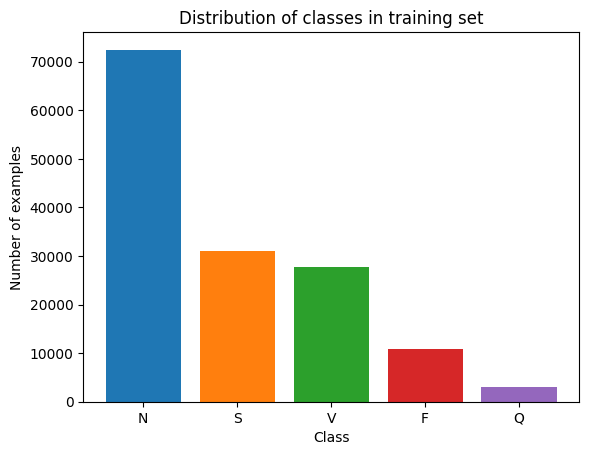

In [58]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
class_names = ['N', 'S', 'V', 'F', 'Q']
plt.bar(class_names, train_df_os.target.value_counts(), color = colors)

plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Distribution of classes in training set')
plt.show()

Get the 1D data into a 2D matrix

In [45]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset

(Heartdataset2D (#144942), Heartdataset2D (#21892))

In [48]:
x, y = traindataset[20]
x.shape, y

(torch.Size([1, 16, 12]), tensor(0))

In [4]:

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

traindataset.to(device)
testdataset.to(device)


Using MPS


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(0, device='mps:0'))

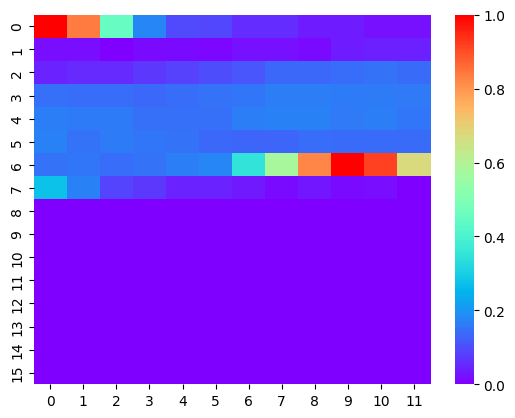

In [5]:
x, y = traindataset[0]
# Assuming your tensor is named 'tensor'
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [6]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(4529, 684)

In [7]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

The ConvBlock makes it easier to stack block in the model.
Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

- Model CNN 2D:
2 layers with ReLU
1 MaxPool2d layer
Dense layer bestaat uit 2 linea layers

Hyperparameters:
- 16 hidden units
- 1 block met 2 conv

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.conv(x)

In [9]:
import torch
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_blocks']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [16]:
from src import models
config = {
    'hidden' : 128,
    'num_blocks' : 1,
    'num_classes' : 5,
    'shape' : shape,

}
print(config)
model = models.CNN(config)
model.to(device)
model(x).shape

2025-01-18 17:45:35.475 | INFO     | src.models:__init__:37 - Activation map size: 48
2025-01-18 17:45:35.475 | INFO     | src.models:__init__:38 - Input linear: 6144


{'hidden': 128, 'num_blocks': 1, 'num_classes': 5, 'shape': (16, 12)}


torch.Size([32, 5])

In [17]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [18]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [19]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv model")

<Experiment: artifact_location='/Users/francesca/code_repo/MADS-exam-25/notebooks/mlruns/1', creation_time=1736881299130, experiment_id='1', last_update_time=1736881299130, lifecycle_stage='active', name='2D conv model', tags={}>

In [40]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [41]:
classes = train_df.target.unique()
class_weights = compute_class_weight('balanced', classes=classes, y=train_df.target)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

In [43]:
#training with class rebalancing through class weights
from mltrainer import Trainer, TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_big_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        )
    trainer.loop()

    #htop om de gpu te zien
    # dimensie transformer reduceren

2025-01-18 22:22:01.049 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250118-222201
100%|██████████| 905/905 [00:07<00:00, 124.04it/s]
2025-01-18 22:22:08.998 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.0290 test 0.0861 metric ['0.9685', '0.9685', '0.8698', '0.9685', '0.9340']
100%|██████████| 905/905 [00:07<00:00, 124.65it/s]
2025-01-18 22:22:16.907 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.0217 test 0.1124 metric ['0.9288', '0.9288', '0.7668', '0.9288', '0.9346']
100%|██████████| 905/905 [00:07<00:00, 126.16it/s]
2025-01-18 22:22:24.754 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.0322 test 0.1183 metric ['0.9658', '0.9658', '0.8568', '0.9658', '0.9499']
100%|██████████| 905/905 [00:07<00:00, 123.62it/s]
2025-01-18 22:22:32.734 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.0215 test 0.1163 metric ['0.9520', '0.9520', '0.8199', '0.9520', '0.9427']
100%|██████████| 905/905 [00:07<00:00, 122

{'hidden': 128, 'num_blocks': 1, 'num_classes': 5, 'shape': (16, 12)}
test_results=[0.991 0.85  0.96  0.854 0.99 ]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

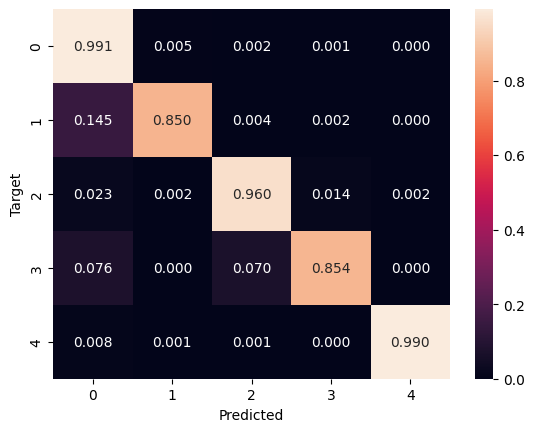

In [50]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

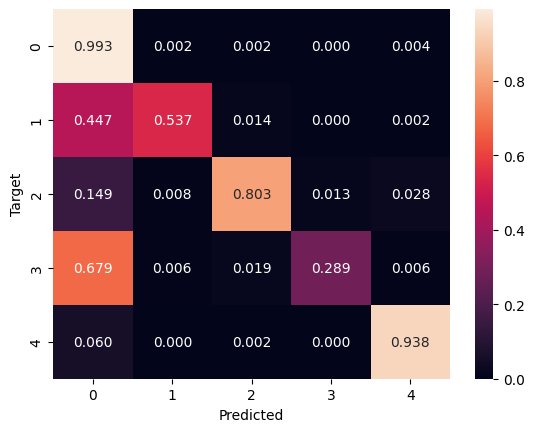

In [ ]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [22]:
from src import models
config = {
    'hidden' : 32,
    'num_blocks' : 2,
    'num_classes' : 5,
    'shape' : shape,

}
model = models.CNN(config)
model.to(device)
model(x).shape

2025-01-15 21:34:11.075 | INFO     | src.models:__init__:37 - Activation map size: 48
2025-01-15 21:34:11.075 | INFO     | src.models:__init__:38 - Input linear: 1536


torch.Size([32, 5])

In [25]:
# training with oversampled data
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

    #htop om de gpu te zien
    # dimensie transformer reduceren

2025-01-16 09:46:22.537 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250116-094622
100%|██████████| 547/547 [00:05<00:00, 104.05it/s]
2025-01-16 09:46:28.401 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4959 test 0.2791 metric ['0.9216', '0.9216', '0.6519', '0.9216', '0.6592']
100%|██████████| 547/547 [00:05<00:00, 104.97it/s]
2025-01-16 09:46:34.234 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2230 test 0.1938 metric ['0.9458', '0.9458', '0.7502', '0.9458', '0.7444']
100%|██████████| 547/547 [00:05<00:00, 104.66it/s]
2025-01-16 09:46:40.075 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1701 test 0.1553 metric ['0.9596', '0.9596', '0.8009', '0.9596', '0.8059']
100%|██████████| 547/547 [00:05<00:00, 104.50it/s]
2025-01-16 09:46:45.919 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1526 test 0.1541 metric ['0.9568', '0.9568', '0.7908', '0.9568', '0.8047']
100%|██████████| 547/547 [00:05<00:00, 104

In [ ]:
def confusion_matrix(X, y):
    y_true = []
    y_pred = []
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

    yhat = [x for y in y_pred for x in y]
    y = [x for y in y_true for x in y]

    cfm = confusion_matrix(y, yhat)
    cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

    return cfm

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

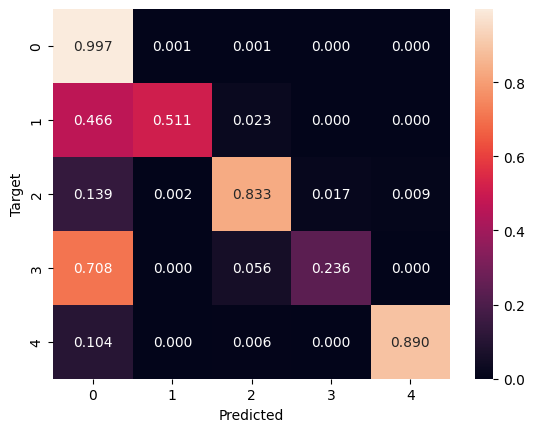

In [26]:
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")